In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
# !pip install geopy
# !pip install geopandas

In [ ]:
# from geopy.geocoders import Nominatim
# import time
# geolocator = Nominatim(user_agent="myGeocoder")
# location = geolocator.geocode('Honolulu,  HI')

In [1]:
# manual parsing for some MSA
cache = {'Augusta, GA':(-81.966667, 33.466667), 'Birmingham, AL':(-86.779633, 33.543682), 'Denver, CO': (-104.991531, 39.742043)}

In [2]:
cache['Toledo, OH'] = (-83.5379, 41.664494)

In [3]:
import time
from geopy.geocoders import Nominatim
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

geolocator = Nominatim(user_agent="myGeocoder")

def convert_to_lat(loc):
  if loc in cache:
    return cache[loc][1]
  else:
    location = geolocator.geocode(loc)
    time.sleep(0.5)
    cache[loc] = (location.longitude, location.latitude)
    return cache[loc][1]

def convert_to_long(loc):
  if loc in cache:
    return cache[loc][0]
  else:
    location = geolocator.geocode(loc)
    time.sleep(0.5)
    cache[loc] = (location.longitude, location.latitude)
    return cache[loc][0]
  

In [10]:
df = pd.read_csv('processed_urinary.csv', delimiter='\t')

In [12]:
df.drop(['Notes', 'MSA Code'], axis=1, inplace=True)
df = df.dropna()

In [13]:
df = df[df['MSA'] != 'Other']
# Does not consider Haiwai
df = df[~df['MSA'].isin(['Honolulu, HI', 'Urban Honolulu, HI'])]
df = df[df['Crude Rate'] != 'Not Applicable']
def parse_loc(loc):
  city, state = loc.split(',')
  return city.split('-')[0].strip()+", "+state.split('-')[0].strip()
df['MSA'] = df['MSA'].apply(parse_loc)
df['MSA'].replace({'Winston, NC': 'Winston-Salem, NC'}, inplace=True)

In [14]:
df['latitude'] = df['MSA'].apply(convert_to_lat)
df['longitude'] = df['MSA'].apply(convert_to_long)

KeyboardInterrupt: 

In [43]:
df.head()

,MSA,Sex,Sex Code,Race,Race Code,Year,Year Code,Leading Cancer Sites,Leading Cancer Sites Code,Count,Population,Crude Rate,latitude,longitude,geometry
0,"Akron, OH",Female,F,White,2106-3,1999.0,1999.0,Brain and Other Nervous System,31010-31040,17.0,310511,5.5,41.042874,-81.697997,POINT (-81.69800 41.04287)
1,"Akron, OH",Female,F,White,2106-3,2000.0,2000.0,Brain and Other Nervous System,31010-31040,26.0,310857,8.4,41.042874,-81.697997,POINT (-81.69800 41.04287)
2,"Akron, OH",Female,F,White,2106-3,2001.0,2001.0,Brain and Other Nervous System,31010-31040,17.0,310845,5.5,41.042874,-81.697997,POINT (-81.69800 41.04287)
3,"Akron, OH",Female,F,White,2106-3,2002.0,2002.0,Brain and Other Nervous System,31010-31040,24.0,310777,7.7,41.042874,-81.697997,POINT (-81.69800 41.04287)
4,"Akron, OH",Female,F,White,2106-3,2003.0,2003.0,Brain and Other Nervous System,31010-31040,22.0,310310,7.1,41.042874,-81.697997,POINT (-81.69800 41.04287)


In [34]:
df = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

In [35]:
pdf = pd.read_csv('global_power_plant_database.csv')
pdf = pdf[pdf['country'] == 'USA']
pdf = pdf[pdf['primary_fuel'] == 'Nuclear']

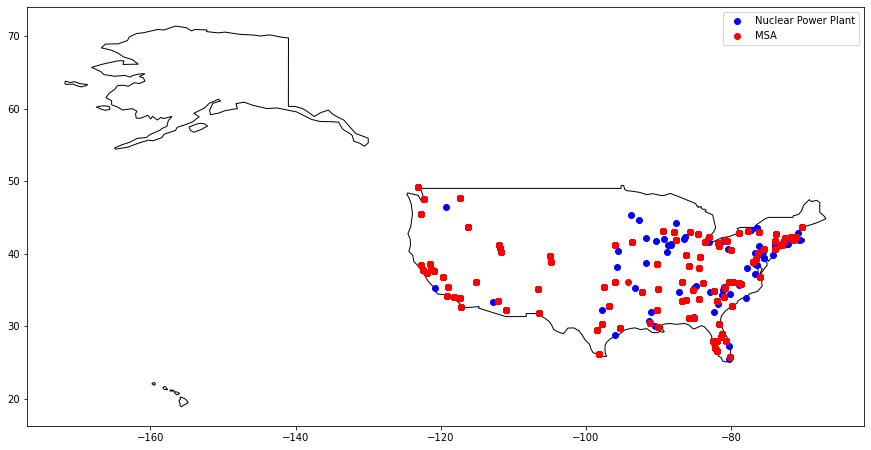

In [36]:
pdf = geopandas.GeoDataFrame(
    pdf, geometry=geopandas.points_from_xy(pdf.longitude, pdf.latitude))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'United States of America'].plot(
    color='white', edgecolor='black', figsize=(15, 15))
pdf.plot(ax=ax, color='blue')
df.plot(ax=ax, color='red')
ax.legend(['Nuclear Power Plant', 'MSA'])
plt.show(ax)

In [37]:
# distance to closet nuclear power plant
from geopy.distance import distance, lonlat

dist_cache = {}
plant_cache = {}
def get_shortest_distance(cur, plants):
  if cur in dist_cache:
    return dist_cache[cur]
  min_dist = np.inf
  min_plant = ""
  for plant in plants:
    dist = distance(lonlat(*cur), lonlat(*plant)).miles
    if min_dist > dist:
      min_dist = dist
      min_plant = plant
  dist_cache[cur] = min_dist
  plant_cache[cur] = min_plant
  return min_dist

In [38]:
power_plants_latlon = list(zip(pdf.longitude, pdf.latitude))
msa_plants_latlon = list(zip(df.longitude, df.latitude))
df['min_dist'] = list(map(lambda x: get_shortest_distance(x, power_plants_latlon), msa_plants_latlon))
df['min_dist_squared'] = df['min_dist']**2

In [39]:
df['capacity'] = list(map(lambda x: pdf.iloc[(power_plants_latlon).index(plant_cache[x])].capacity_mw, msa_plants_latlon))
df['plant_name'] = list(map(lambda x: pdf.iloc[(power_plants_latlon).index(plant_cache[x])]['name'], msa_plants_latlon))

In [40]:
from scipy import stats
import statsmodels.api as sm

In [41]:
df['Crude Rate'] = df['Crude Rate'].astype(float)

In [42]:
X = sm.add_constant(df.loc[:, 'min_dist'])
est = sm.OLS(df['Crude Rate'], X)
est = est.fit(cov_type='HC1')
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             Crude Rate   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     49.10
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           2.85e-12
Time:                        13:28:21   Log-Likelihood:                -8672.8
No. Observations:                3926   AIC:                         1.735e+04
Df Residuals:                    3924   BIC:                         1.736e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8082      0.050    154.663      0.0

In [43]:
X = sm.add_constant(df.loc[:, ['min_dist', 'capacity']])
est = sm.OLS(df['Crude Rate'], X)
est = est.fit(cov_type='HC1')
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             Crude Rate   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     76.82
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           1.88e-33
Time:                        13:28:21   Log-Likelihood:                -8640.1
No. Observations:                3926   AIC:                         1.729e+04
Df Residuals:                    3923   BIC:                         1.730e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3525      0.072    116.041      0.0

In [44]:
df.loc[df['Sex'] == "Female", ['Sex']] = 0 
df.loc[df['Sex'] == "Male", ['Sex']] = 1
df['Sex'] = df['Sex'].astype(int)
df['Black'] = 0
df['Asian'] = 0
df.loc[df['Race'] == 'Black or African American', 'Black'] = 1
df.loc[df['Race'] == 'Asian or Pacific Islander', 'Asian'] = 1

In [45]:
X = sm.add_constant(df[['min_dist', 'Sex', 'Black', 'Asian']])
est = sm.OLS(df['Crude Rate'], X)
est = est.fit(cov_type='HC1')
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             Crude Rate   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     1605.
Date:                Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                        13:28:21   Log-Likelihood:                -7178.2
No. Observations:                3926   AIC:                         1.437e+04
Df Residuals:                    3921   BIC:                         1.440e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5854      0.040    189.195      0.0

In [46]:
df.to_csv('processed_brain_more.csv')